In [6]:
%reset -f
import copy,h5py,os,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import block_diag

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]

#set constant matrices
ROW=np.array([[0,0,0,0],[1,1,1,1],[2,2,2,2],[3,3,3,3]])
COL=np.array([[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3]])

def import_mesh(infile):
    print('Reading group mesh from %s'%infile)
    with h5py.File(infile,'r') as file:
        nodes=np.array(file['mesh/nodes'])
        elements=np.array(file['mesh/elements'])
        faces=np.array(file['mesh/faces'])
        
        in_active_zones=np.array(file['mesh/in_active_zones'])
        with_first_kind_bc=np.array(file['mesh/with_first_kind_bc'])
        with_third_kind_bc=np.array(file['mesh/with_third_kind_bc'])
        
        in_electrolyte=np.array(file['mesh/in_electrolyte'])
        in_solid=np.array(file['mesh/in_solid'])
        in_stern=np.array(file['mesh/in_stern'])
        
        #compute middle point of each element (efficiency to be improved)
        nelem=len(elements[:,0])
        midpoints=np.zeros((nelem,3))
        for i in range(0,nelem):
            for j in range(0,3):
                midpoints[i,j]=.25*sum(nodes[elements[i,:],j])
        
        nind_e=np.unique(elements[in_active_zones].flatten(order='C'))
        print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
        print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
        print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
        print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
        print('')
        
        mesh={'elements':elements,'nodes':nodes,'faces':faces,
              'in_active_zones':in_active_zones,
              'with_first_kind_bc':with_first_kind_bc,
              'with_third_kind_bc':with_third_kind_bc,
              'in_electrolyte':in_electrolyte,
              'in_solid':in_solid,
              'in_stern':in_stern,
              'midpoints':midpoints}
    
    return mesh

def import_physics(infile):
    print('Reading group physics from %s'%infile)
    with h5py.File(infile,'r') as file:
        rel_perm_electrolyte=np.array(file['physics/rel_perm_electrolyte'])
        rel_perm_solid=np.array(file['physics/rel_perm_solid'])
        diffusion_electrolyte=np.array(file['physics/diffusion_electrolyte'])
        diffusion_stern=np.array(file['physics/diffusion_stern'])
        mobility_electrolyte=np.array(file['physics/mobility_electrolyte'])
        mobility_stern=np.array(file['physics/mobility_stern'])
        temp_K=np.array(file['physics/temperature'])
        cinf=np.array(file['physics/ion_conc_inf'])
        zval=np.array(file['physics/ion_val'])
        sigma_ss=np.array(file['physics/sigma_ss'])
        
        print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
        print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
        print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
        print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
        print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
        print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
        print('TEMPERATURE IS:',temp_K)
        print('ION COCENTRATION AT INFINITY IS:',cinf)
        print('ION VALENCE IS:',zval)
        print('SURFACE CHARGE DENSITY FOR STEADY STATE IS:',sigma_ss)
        print('')
        
        physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
                'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
                'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
                'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval,
                'sigma_ss':sigma_ss}
    
    return physics

def set_materials(mesh,physics,u,case=1):
    case=np.maximum(1,int(case))
    case=np.minimum(2,int(case))
    print('Setting materials using predefined cases')
    print('TEST CASE IS:',case)
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    rel_perm_electrolyte=physics['rel_perm_electrolyte']
    rel_perm_solid=physics['rel_perm_solid']
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    sigma_ss=physics['sigma_ss']
    
    if case==1:
        c=np.zeros(nelem)
        alpha_x=np.zeros(nelem)
        alpha_y=np.zeros(nelem)
        alpha_z=np.zeros(nelem)

        beta_x=np.zeros(nelem)
        beta_y=np.zeros(nelem)
        beta_z=np.zeros(nelem)

        gamma_x=np.zeros(nelem)
        gamma_y=np.zeros(nelem)
        gamma_z=np.zeros(nelem)
        
        a=np.zeros(nelem)
        f=np.zeros(nelem)
        gs=np.zeros(nface)
        qs=np.zeros(nface)
        snod=np.zeros(nnode)

        c[in_electrolyte]=perm0*rel_perm_electrolyte
        c[in_solid]=perm0*rel_perm_solid
        gs[in_stern]=sigma_ss

        ze=zval*echarge #ion valence times elementary charge
        u_scaled=ze*u/kB/temp_K #scaled potential in elements
        a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        f[:]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)
        a[in_solid]=0
        f[in_solid]=0
        
    elif case==2:
        c=np.zeros((nelem,3,3))
        alpha_x=np.zeros((nelem,3,3))
        alpha_y=np.zeros((nelem,3,3))
        alpha_z=np.zeros((nelem,3,3))
        
        beta_x=np.zeros((nelem,3,3))
        beta_y=np.zeros((nelem,3,3))
        beta_z=np.zeros((nelem,3,3))
        
        gamma_x=np.zeros((nelem,3,3))
        gamma_y=np.zeros((nelem,3,3))
        gamma_z=np.zeros((nelem,3,3))
        
        a=np.zeros((nelem,3,3))
        f=np.zeros((nelem,3))
        gs=np.zeros((nelem,3))
        qs=np.zeros((nelem,3,3))
        snod=np.zeros((nelem,3))
        
        c[in_electrolyte,0,0]=perm0*rel_perm_electrolyte
        c[in_electrolyte,1,1]=perm0*rel_perm_electrolyte
        c[in_electrolyte,2,2]=perm0*rel_perm_electrolyte
        
        c[in_solid,0,0]=perm0*rel_perm_solid
        c[in_solid,1,1]=perm0*rel_perm_solid
        c[in_solid,2,2]=perm0*rel_perm_solid
        
        gs[in_stern,0]=sigma_ss
        gs[in_stern,1]=sigma_ss
        gs[in_stern,2]=sigma_ss
        
        ze=zval*echarge #ion valence times elementary charge
        u_scaled=ze*u/kB/temp_K #scaled potential on nodes
        a[:,0,0]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        a[:,1,1]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        a[:,2,2]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        
        f[:,0]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)
        f[:,1]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)
        f[:,2]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials

def scale_distance(mesh_in,materials_in,dist_factor):
    print('Scaling distance and related materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)
    materials=copy.deepcopy(materials_in)
    
    mesh['nodes']=mesh['nodes']*dist_factor
    mesh['midpoints']=mesh['midpoints']*dist_factor
    
    materials['alpha_x']=materials['alpha_x']/dist_factor
    materials['alpha_y']=materials['alpha_y']/dist_factor
    materials['alpha_z']=materials['alpha_z']/dist_factor
    
    materials['beta_x']=materials['beta_x']/dist_factor
    materials['beta_y']=materials['beta_y']/dist_factor
    materials['beta_z']=materials['beta_z']/dist_factor
    
    materials['gamma_x']=materials['gamma_x']/dist_factor
    materials['gamma_y']=materials['gamma_y']/dist_factor
    materials['gamma_z']=materials['gamma_z']/dist_factor
    
    materials['a']=materials['a']/dist_factor**2
    materials['f']=materials['f']/dist_factor**2    
    materials['gs']=materials['gs']/dist_factor
    materials['qs']=materials['qs']/dist_factor
    materials['snod']=materials['snod']/dist_factor
    
    return mesh,materials

def compute_gradients(nodes,elements,faces,unod,flag=3):
    print('Computing fields and field gradients')
    start=time.time()
    
    if flag==3:
        nelem=len(elements)
        u=np.zeros((nelem,4))
        Je=np.ones((4,4))
        for i in range(nelem): #consider parallelization
            nind=elements[i,:]        
            Je[1:,:]=nodes[nind,:].T
            invJe=np.linalg.inv(Je)

            xr=.25*sum(nodes[nind,0])
            yr=.25*sum(nodes[nind,1])
            zr=.25*sum(nodes[nind,2])
            u[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
            u[i,1]=sum(unod[nind]*invJe[:,1])
            u[i,2]=sum(unod[nind]*invJe[:,2])
            u[i,3]=sum(unod[nind]*invJe[:,3])
    else:
        nface=len(faces)
        u=np.zeros((nface,4))
        Je=np.ones((3,3))
        for i in range(1): #consider parallelization
            nind=faces[i,:]
            R=rotate_triangle(nodes[nind,:])
            nodes_new=R.dot(nodes[nind,:].T).T
            
            Je[1:,:]=nodes_new[:,:-1].T
            invJe=np.linalg.inv(Je)
            
            xr=sum(nodes_new[:,0])/3
            yr=sum(nodes_new[:,1])/3
            u[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])
            
            dudx=sum(unod[nind]*invJe[:,1])
            dudy=sum(unod[nind]*invJe[:,2])
            u[i,1:]=np.linalg.inv(R).dot([dudx,dudy,0])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u

def rotate_triangle(nodes):
    A=np.zeros((3,3))
    R=np.zeros((3,3))
    
    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    k=k/np.linalg.norm(k)
    
    cosb=np.dot(n,z)
    sinb=np.sqrt(1-cosb**2)
    
    A[0,:]=[0,-k[2],k[1]]
    A[1,:]=[k[2],0,-k[0]]
    A[2,:]=[-k[1],k[0],0]
    R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    
    return R

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        ind=np.argmin(dist2)
        output[i,6]=np.real(unod[ind])
        output[i,7]=np.imag(unod[ind])

    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def build_system(mesh,materials,case=1):
    case=np.maximum(1,int(case))
    case=np.minimum(2,int(case))
    if case==1:
        nnode=len(mesh['nodes'])
        K=csr_matrix((nnode,nnode))
        b=np.zeros(nnode,dtype=complex)
        K,b=assemble_Ke(mesh,materials,K,b,offset=(0,0))
        K,b=set_third_kind_bc(mesh,materials,K,b,offset=(0,0))                
        K,b=set_first_kind_bc(mesh,materials,K,b,offset=(0,0))
    elif case==2:
        nnode=len(mesh['nodes'])
        K=csr_matrix((nnode*3,nnode*3))
        b=np.zeros(nnode,dtype=complex)
        
    return K,b

def assemble_Ke(mesh,materials,K_in,b_in,offset=(0,0)):
    print('Assembling the system of equations')
    start=time.time()
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    nnode=len(mesh['nodes'])
    nelem=len(mesh['elements'])
    
    cx=materials['cx']
    cy=materials['cy']
    cz=materials['cz']
    alpha_x=materials['alpha_x']
    alpha_y=materials['alpha_y']
    alpha_z=materials['alpha_z']
    beta_x=materials['beta_x']
    beta_y=materials['beta_y']
    beta_z=materials['beta_z']
    gamma_x=materials['gamma_x']
    gamma_y=materials['gamma_y']
    gamma_z=materials['gamma_z']
    a=materials['a']
    f=materials['f']
    
    cnt=K_in.getnnz()
    I=np.zeros(cnt+nelem*16,dtype=int)
    J=np.zeros(cnt+nelem*16,dtype=int)
    V=np.zeros(cnt+nelem*16,dtype=complex)
    I[:cnt]=K_in.nonzero()[0]
    J[:cnt]=K_in.nonzero()[1]
    V[:cnt]=K_in.data
    b=np.array(b_in)
    for i in range(nelem):
        nind=elements[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                       alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                       beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                       gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                       a=a[i],f=f[i])
        I[cnt:cnt+16]=nind[ROW[:4,:4]].flatten(order='C')+offset[0]
        J[cnt:cnt+16]=nind[COL[:4,:4]].flatten(order='C')+offset[1]
        V[cnt:cnt+16]=Ke.flatten(order='C')
        b[nind+offset[0]]=b[nind+offset[0]]+be
        cnt=cnt+16
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_third_kind_bc(mesh,materials,K_in,b_in,offset=(0,0)):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']
    
    nodes=mesh['nodes']
    faces=mesh['faces'][with_third_kind_bc]
    nnode=len(nodes)
    nface=len(faces)
    
    gs=materials['gs'][with_third_kind_bc]
    qs=materials['qs'][with_third_kind_bc]
    
    cnt=K_in.getnnz()
    I=np.zeros(cnt+nface*9,dtype=int)
    J=np.zeros(cnt+nface*9,dtype=int)
    V=np.zeros(cnt+nface*9,dtype=complex)
    I[:cnt]=K_in.nonzero()[0]
    J[:cnt]=K_in.nonzero()[1]
    V[:cnt]=K_in.data
    b=np.array(b_in)
    for i in range(nface):
        nind=faces[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks(xnod,ynod,znod,gs=gs[i],qs=qs[i])
        I[cnt:cnt+9]=nind[ROW[:3,:3]].flatten(order='C')+offset[0]
        J[cnt:cnt+9]=nind[COL[:3,:3]].flatten(order='C')+offset[1]
        V[cnt:cnt+9]=Ks.flatten(order='C')
        b[nind+offset[0]]=b[nind+offset[0]]+bs
        cnt=cnt+9
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_first_kind_bc(mesh,materials,K_in,b_in,offset=(0,0)):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod=materials['snod'][with_first_kind_bc]
    
    nind0=np.where(~with_first_kind_bc)[0]
    nind1=np.where(with_first_kind_bc)[0]
    b[nind1+offset[0]]=snod
    for i in nind0:
        row=i+offset[0]
        cols=nind1+offset[1]
        b[row]=b[row]-K[row,cols].dot(snod)
    
    K=zero_rows(K,nind1+offset[0])
    K=zero_cols(K,nind1+offset[1])
    diag=csr_matrix(K.shape).tolil()
    diag[nind1+offset[0],nind1+offset[1]]=1
    K=K+diag
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_subdomains(mesh_in,materials_in):
    print('Re-indexing elements and faces for subdomains')
    print('')
    mesh=copy.deepcopy(mesh_in)
    materials=copy.deepcopy(materials_in)
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    in_active_zones=mesh['in_active_zones']
    with_first_kind_bc=mesh['with_first_kind_bc']
    with_third_kind_bc=mesh['with_third_kind_bc']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    midpoints=mesh['midpoints']
    
    nind=np.unique(elements[in_active_zones].flatten(order='C'))
    nind_global_to_local=-np.ones(len(nodes),dtype=int)
    nind_global_to_local[nind]=np.arange(len(nind)) #value of -1 is out of comput. domain
    fmask=((faces[:,0]!=-1)&(faces[:,1]!=-1))&(faces[:,2]!=-1) #value of False is out of comput. domain
    
    mesh['nodes']=nodes[nind,:]
    mesh['elements']=nind_global_to_local[elements[in_active_zones,:]]
    mesh['faces']=nind_global_to_local[faces[fmask,:]]
    mesh['midpoints']=midpoints[nind,:]
    
    mesh['in_active_zones']=np.ones(len(elements),dtype=bool)
    mesh['with_first_kind_bc']=with_first_kind_bc[nind]
    mesh['with_third_kind_bc']=with_third_kind_bc[fmask]
    
    mesh['in_solid']=in_solid[in_active_zones]
    mesh['in_electrolyte']=in_electrolyte[in_active_zones]
    mesh['in_stern']=in_stern[fmask]
    
    materials['cx']=materials['cx'][in_active_zones]
    materials['cy']=materials['cy'][in_active_zones]
    materials['cz']=materials['cz'][in_active_zones]
    materials['alpha_x']=materials['alpha_x'][in_active_zones]
    materials['alpha_y']=materials['alpha_y'][in_active_zones]
    materials['alpha_z']=materials['alpha_z'][in_active_zones]
    materials['beta_x']=materials['beta_x'][in_active_zones]
    materials['beta_y']=materials['beta_y'][in_active_zones]
    materials['beta_z']=materials['beta_z'][in_active_zones]
    materials['gamma_x']=materials['gamma_x'][in_active_zones]
    materials['gamma_y']=materials['gamma_y'][in_active_zones]
    materials['gamma_z']=materials['gamma_z'][in_active_zones]
    
    materials['a']=materials['a'][in_active_zones]
    materials['f']=materials['f'][in_active_zones]    
    materials['gs']=materials['gs'][fmask]
    materials['qs']=materials['qs'][fmask]
    materials['snod']=materials['snod'][nind]
    
    return mesh,materials

def build_Ke(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,
             beta_x,beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f):
    Ke=np.zeros((4,4),dtype=complex)
    be=np.zeros(4,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6
    
    for i in range(4):
        for j in range(4):
            delta=1-np.abs(np.sign(i-j))
            Ke[i,j]=(cx*invJe[i,1]*invJe[j,1]+cy*invJe[i,2]*invJe[j,2]+
                     cz*invJe[i,3]*invJe[j,3]+a*(1+delta)/20+
                     (alpha_x*invJe[i,1]+alpha_y*invJe[i,2]+alpha_z*invJe[i,3])/4+
                     (beta_x*invJe[j,1]+beta_y*invJe[j,2]+beta_z*invJe[j,3])/4)*vol
        be[i]=be[i]+(gamma_x*invJe[i,1]+gamma_y*invJe[i,2]+
                     gamma_z*invJe[i,3]+f/4)*vol
    
    return Ke,be

def build_Ks(xnod,ynod,znod,gs,qs):
    Ks=np.zeros((3,3),dtype=complex)
    bs=np.zeros(3,dtype=complex)
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    for i in range(3):
        for j in range(3):
            delta=1-np.abs(np.sign(i-j))
            Ks[i,:]=qs*area*(1+delta)/12
        bs[i]=gs*area/3
    
    return Ks,bs

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r]=0
    
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c]=0
    
    return M.dot(diag)
    
def solve_unod(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    unod=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    return unod

def an_sol(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag=0):
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    
    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm
    
    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

if __name__=='__main__':
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    materials=set_materials(mesh,physics,u=0,case=1)
    mesh_scaled,materials_scaled=scale_distance(mesh,materials,dist_factor)
    mesh_subset,materials_subset=set_subdomains(mesh_scaled,materials_scaled)
    K,b=build_system(mesh_subset,materials_subset)
    unod=solve_unod(K/perm0,b/perm0)
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nind=np.unique(elements[in_active_zones,:].flatten(order='C'))
    unod=np.zeros(len(nodes),dtype=complex)
    unod[nind]=solve_unod(K,b)
    output=output_unod(nodes,unod,srvfile)
    ansol=an_sol(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                 cinf=100,zval=1,zeta=0.01,gradflag=1)
    #u=compute_gradients(nodes,elements,faces,unod,flag=2)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: 0.01

Setting materials using predefined cases
TEST CASE IS: 1

Scaling distance and related materials
DISTANCE SCALING FACTOR IS: 1.00e+09

Re-indexing elements and faces for subdomains

Assembling the system of equations
Time elapsed  15.610732078552246 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.19240522

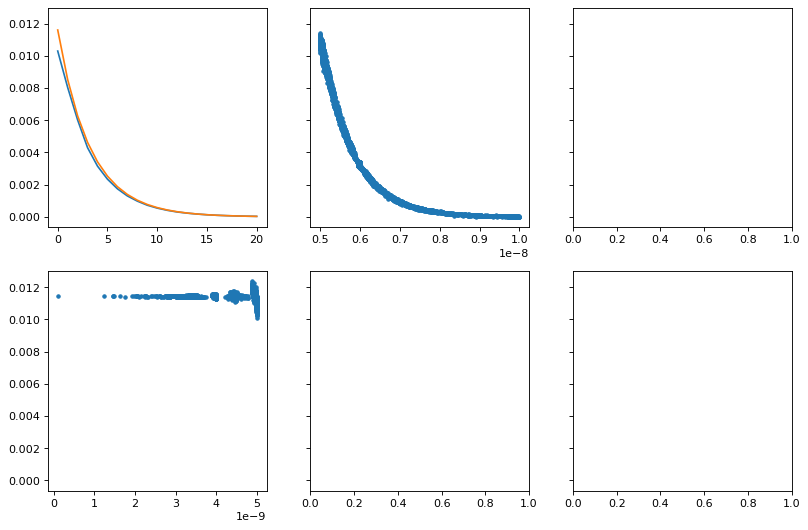

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots(2,3,sharey=True,figsize=(12,8),dpi=80)
axs=ax.flatten()

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
mask=(dist>5e-9)&(dist<6e-9)
# axs[0].plot(dist[mask]*1e9,unod[mask],'*')
axs[0].plot(output[:,6])
axs[0].plot(ansol[:,0])
mask=(dist>5e-9)&(dist<10e-9)
axs[1].plot(dist[mask],np.real(unod[mask]),'.')
mask=dist<=5e-9
axs[3].plot(dist[mask],np.real(unod[mask]),'.')

In [27]:
# I3=K.nonzero()[0]
# J3=K.nonzero()[0]
# V3=K.data
# print(len(I3))
# print(K.shape[0])
B=csr_matrix((3, 4), dtype=np.int8)
type(B.shape)
# B.getnnz()

tuple

In [33]:
# print(len(materials_subset['gamma_x']))
# print(len(materials_subset['gs']))
# print(len(mesh_subset['faces']))

# # print('')
# # print(mesh_subset['with_third_kind_bc'])
# print(mesh_subset['faces'])

# def change_size(mesh_in):
#     mesh=dict(mesh_in)
#     with_third_kind_bc=mesh['with_third_kind_bc']
#     #faces=mesh_subset['faces'][with_third_kind_bc]
#     faces=mesh['faces'][with_third_kind_bc]
#     faces[0]=[1,0,0]
# #     mesh['faces'][0]=[0,0,0]
#     return mesh

# mesh_resize=change_size(mesh_subset)
# faces_old=mesh_subset['faces']
# faces_new=mesh_resize['faces']
# print(faces_old[0])
# print(faces_new[0])
# print(len(faces_old))
# print(len(faces_new))

# with_third_kind_bc=mesh_subset['with_third_kind_bc']

# print(len(mesh['with_third_kind_bc']))
# print(len(mesh_subset['with_third_kind_bc']))
# print(len(mesh['faces']))
# print(len(mesh_subset['faces']))
# print((mesh_subset['faces'][with_third_kind_bc]))

print(mesh['nodes'])
print(mesh_subset['nodes'])

[[ 1.1509443e-06  1.1509443e-06  1.1509443e-06]
 [ 1.1509443e-06 -1.1509443e-06  1.1509443e-06]
 [-1.1509443e-06 -1.1509443e-06  1.1509443e-06]
 ...
 [ 5.8611174e-09 -1.7160823e-09 -4.3860571e-10]
 [ 5.7502190e-09 -7.8544959e-10 -7.7046014e-10]
 [ 5.8840173e-09 -1.6609103e-09  5.2751387e-10]]
[[ 1.1509443e+03  1.1509443e+03  1.1509443e+03]
 [ 1.1509443e+03 -1.1509443e+03  1.1509443e+03]
 [-1.1509443e+03 -1.1509443e+03  1.1509443e+03]
 ...
 [ 5.8611174e+00 -1.7160823e+00 -4.3860570e-01]
 [ 5.7502189e+00 -7.8544956e-01 -7.7046013e-01]
 [ 5.8840175e+00 -1.6609102e+00  5.2751386e-01]]


In [5]:
#Remarks
#check coefficients against equations
#be careful of copying and reassign values in numpy array
#export frequencies
#add pot_inf,ex_inf,ey_inf,ez_inf variables and assign s appropriately
#test case case=0 to test set_subdomains

# sctr=np.array([3,4,5,6])
# # sctr=[3,4,5,6]
# print(sctr[ROW[:4,:4]].flatten(order='C'))
# print(sctr[COL[:4,:4]].flatten(order='C'))
# # print(np.matlib.repmat(sctr,4,1).flatten(order='F'))
# # print(np.matlib.repmat(sctr,4,1).flatten(order='C'))
# # sctr[np.array([0,1])+1]
# sctr=np.array([7,8,9])
# print(sctr[ROW[:3,:3]].flatten(order='C'))
# print(sctr[COL[:3,:3]].flatten(order='C'))
print('BEFORE')
print(np.sum(mesh_scaled['in_stern']))
print('AFTER')
print(np.sum(mesh_subset['in_stern']))
print(materials['cx'][0])
print(materials['cy'][0])
print(materials['cz'][0])
materials['cx'][0]=1
print('Value changed')
print(materials['cx'][0])
print(materials['cy'][0])
print(materials['cz'][0])

BEFORE
2044
AFTER
2044
6.94725e-10
6.94725e-10
6.94725e-10
Value changed
1.0
6.94725e-10
6.94725e-10


In [34]:
test=dict.fromkeys(['X','Y','Z'])
def change_value(test):
    x=0
    return test
